# Data Visualization Course Project


## Songs visualization: lyrics and music


### Developed by:
    Roman Marakulin
    Vladimir Shilov

# Song = Lyrics + Text

### Let us visualize them BOTH...
and then combine visualizations...

In [383]:
#Text
import pandas as pd
from youtube_transcript_api import YouTubeTranscriptApi
import paralleldots

#Music
from chromagram import *
from parameters import *
from chordgram import *
import librosa
import librosa.display

#Animation
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyBboxPatch, colors
from celluloid import Camera
import matplotlib.animation as animation

#Util
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display

from pandasql import sqldf
import time
from IPython.display import HTML
from IPython.display import Video
from tqdm import tqdm

In [384]:
_ID = 'DyDfgMOUjCI'

# Text analysis

## Getting texts
We are going to analyze Bad Guy by Billie Eilish

In [385]:
txt = YouTubeTranscriptApi.get_transcript(_ID, languages=['en-GB', 'en'])

In [386]:
import re
def getWords(text):
    return ' '.join(re.compile('\w+').findall(text))

In [387]:
words = []
start = []
end = []
for i in txt:
    words.append(i['text'])
    start.append(i['start'])
    end.append(i['start']+i['duration'])
text_info = pd.DataFrame({'words':words,'start':start,'end':end})

In [388]:
text_info['words'] = text_info['words'].apply(getWords)

In [389]:
text_info.head(4)

,words,start,end
0,MY INVISILINE HAS FINALLLY LAUGHTER,3.333,5.066
1,I HAVE TAKEN OUT MY INVISILINE I HAVE TAKEN OUT,5.100,6.566
2,MY INVISILINE AND THIS IS THE ALBUM,6.600,9.066
3,LAUGHTER,9.100,13.333


## Text Blob Visualization

## Emotions Extraction

In [390]:
paralleldots.set_api_key('U2JyO3HMs2zjyRpa0RynVrtKtwAb5MskUhESanrxv4U')

In [391]:
un_lines = text_info[text_info['words']!='']['words'].unique()


columns = ['words','Happy','Excited','Bored','Angry','Fear','Sad']
text_emotions = pd.DataFrame(columns=columns)
text_emotions['words'] = un_lines

emts = []
st = 50
for i in np.array_split(un_lines, int(len(un_lines)/20)+1):
    print('api call')
    response=paralleldots.batch_emotion(list(i))
    emts = emts + response['emotion']
    if len(emts) >= st:
        print('waiting')
        time.sleep(80)
        st+=50

emotions = []
for emt in emts:
    emotions.append([emt['Happy'], emt['Excited'], emt['Bored'], 
                     emt['Angry'], emt['Fear'], emt['Sad']])
text_emotions[columns[1:]]=np.array(emotions)
text_emotions.loc[len(text_emotions)] = ['', 0.0,0.0,0.0,0.0,0.0,0.0]
text_emotions.head(4)

api call
api call
api call
waiting


,words,Happy,Excited,Bored,Angry,Fear,Sad
0,MY INVISILINE HAS FINALLLY LAUGHTER,0.202858,0.42344,0.0147983,0.0349381,0.206731,0.117235
1,I HAVE TAKEN OUT MY INVISILINE I HAVE TAKEN OUT,0.0273185,0.0359242,0.0213945,0.208846,0.272583,0.433934
2,MY INVISILINE AND THIS IS THE ALBUM,0.279196,0.314603,0.0666343,0.0591718,0.136044,0.14435
3,LAUGHTER,0.325487,0.358419,0.0150404,0.0568493,0.178885,0.0653193


In [296]:
text_emotions.to_csv(_ID+'.csv',header=True, index=False)

In [411]:
text_emotions = pd.read_csv(_ID+'.csv')
text_emotions = text_emotions.replace(np.nan,'', regex=True)
text_emotions.tail(5)

,words,Happy,Excited,Bored,Angry,Fear,Sad
51,BUT MAYBE IT S CUZ,0.126869,0.150899,0.198634,0.104649,0.278616,0.140333
52,I M WEARING YOUR COLOGNE,0.495803,0.166433,0.000000,0.049910,0.193528,0.094326
53,I M A BAD GUY,0.120841,0.214719,0.063458,0.153490,0.169860,0.277632
54,BAD GUY BAD GUY,0.257144,0.501283,0.018629,0.116330,0.058399,0.048214
55,,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Music visualization

## Downloading music

In [404]:
from __future__ import unicode_literals
import youtube_dl


ydl_opts = {
    'format': 'bestaudio/best',
    'outtmpl': _ID+'.mp3',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'mp3',
        'preferredquality': '192',
    }],
}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['http://www.youtube.com/watch?v='+_ID])

[youtube] DyDfgMOUjCI: Downloading webpage
[download] DyDfgMOUjCI.mp3 has already been downloaded
[download] 100% of 3.55MiB
[ffmpeg] Post-process file DyDfgMOUjCI.mp3 exists, skipping


In [405]:
y, sr = librosa.load(_ID+'.mp3')

/home/vldplcd/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [406]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

In [407]:
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, bins_per_octave=36)
time_p_f = librosa.frames_to_time(np.arange(len(librosa.samples_to_time(C)[0])+1), sr=sr, hop_length=512)[:-1]
H = chordgram(C,display = False)
chords = chord_sequence(H)
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
dBs = np.max(log_S.T,axis = 1)

In [15]:
audio_info = pd.DataFrame({'time':time_p_f,'chord':chords,'dB':dBs})

In [412]:
q = """ select ai.*, te.*, ti.start, ti.end 
from audio_info as ai
left join text_info as ti
on ai.time >= ti.start and ai.time < ti.end
left join text_emotions as te
on te.words = coalesce(ti.words,'')
"""
res = sqldf(q)

In [401]:
res.head(5)

,time,chord,dB,words,Happy,Excited,Bored,Angry,Fear,Sad,start,end
0,0.00000,D,-80.0,,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
1,0.02322,D,-80.0,,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
2,0.04644,D,-80.0,,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
3,0.06966,A,-80.0,,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
4,0.09288,NC,-80.0,,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN


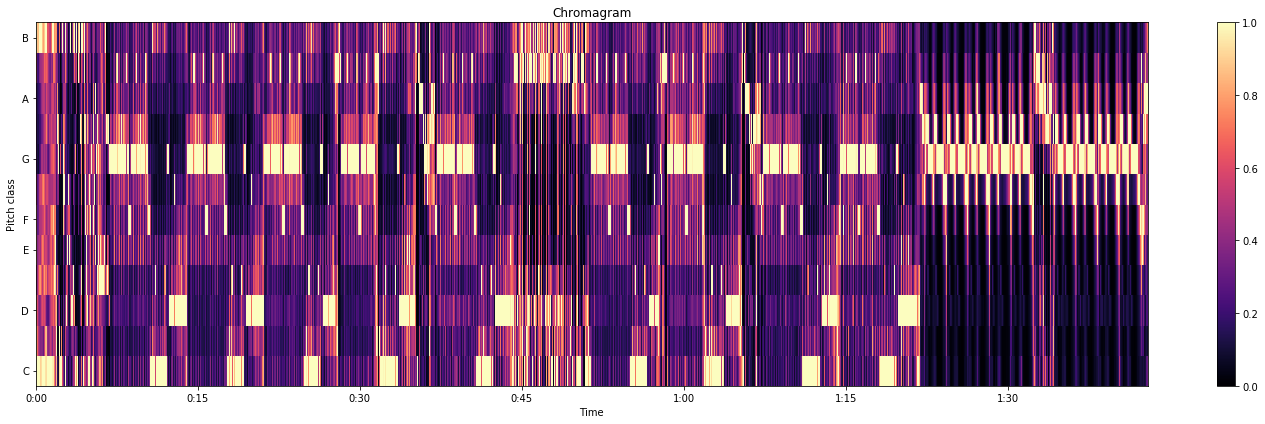

In [402]:
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, bins_per_octave=36)
plt.figure(figsize=(20,6))
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

<Figure size 1440x432 with 0 Axes>

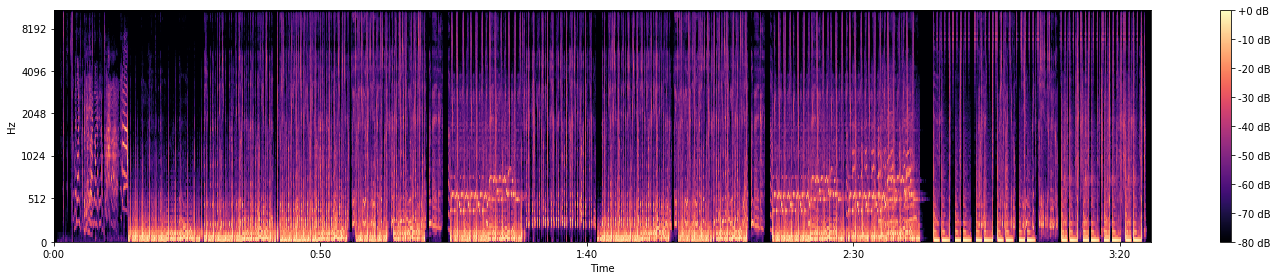

In [408]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(20, 6))
tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout();

# Combining Visualizations

For every second we will take:
* Emotions set from the line
* Chord sentiment (major/minor) that will echance correlated emotions
* Volume (db)

## Stackplot
* Emotions -> Color
* Emotion value -> colored element proportion
* Chord sentiment -> increasing proportions of correlated emotions and decreasing of the others
* Volume -> Size of stack

In [413]:
def stackplt():
    fig = plt.figure(figsize=(20,8), dpi=200, facecolor='#EEEDED')
    volume = res['dB'].to_numpy()+80
    ems = res[columns[1:]]
    d = []
    ch_eff=1.5
    ord_c = ['Angry','Fear','Sad','Bored','Happy', 'Excited']
    pal = ["#F83056", "#513B64", "#247DEF", "#AECDCB", '#E6F832', '#FB48D0']
    ws = int(0.02*len(volume))
    for c in ord_c:
        if c in ['Angry', 'Sad', 'Fear']:
            res['ch'] = [1 if ch == 'NC' else 1/ch_eff if ch[-1] != 'm' else ch_eff for ch in res['chord']]
        elif c in ['Happy', 'Excited']:
            res['ch'] = [1 if ch == 'NC' else ch_eff if ch[-1] != 'm' else 1/ch_eff for ch in res['chord']]
        else:
            res['ch'] = [2 for ch in res['chord']]

        d.append(((ems[c]*res['ch']+0.01)*(res['dB'] + 80)).rolling(window=ws).mean().to_numpy())
    d = np.stack(d, axis=1)

    plt.axis('off')
    plt.stackplot(range(len(d)), d.T, baseline='wiggle',labels=ord_c, colors=pal)

    plt.savefig('graph.svg', format='svg')
    plt.show()




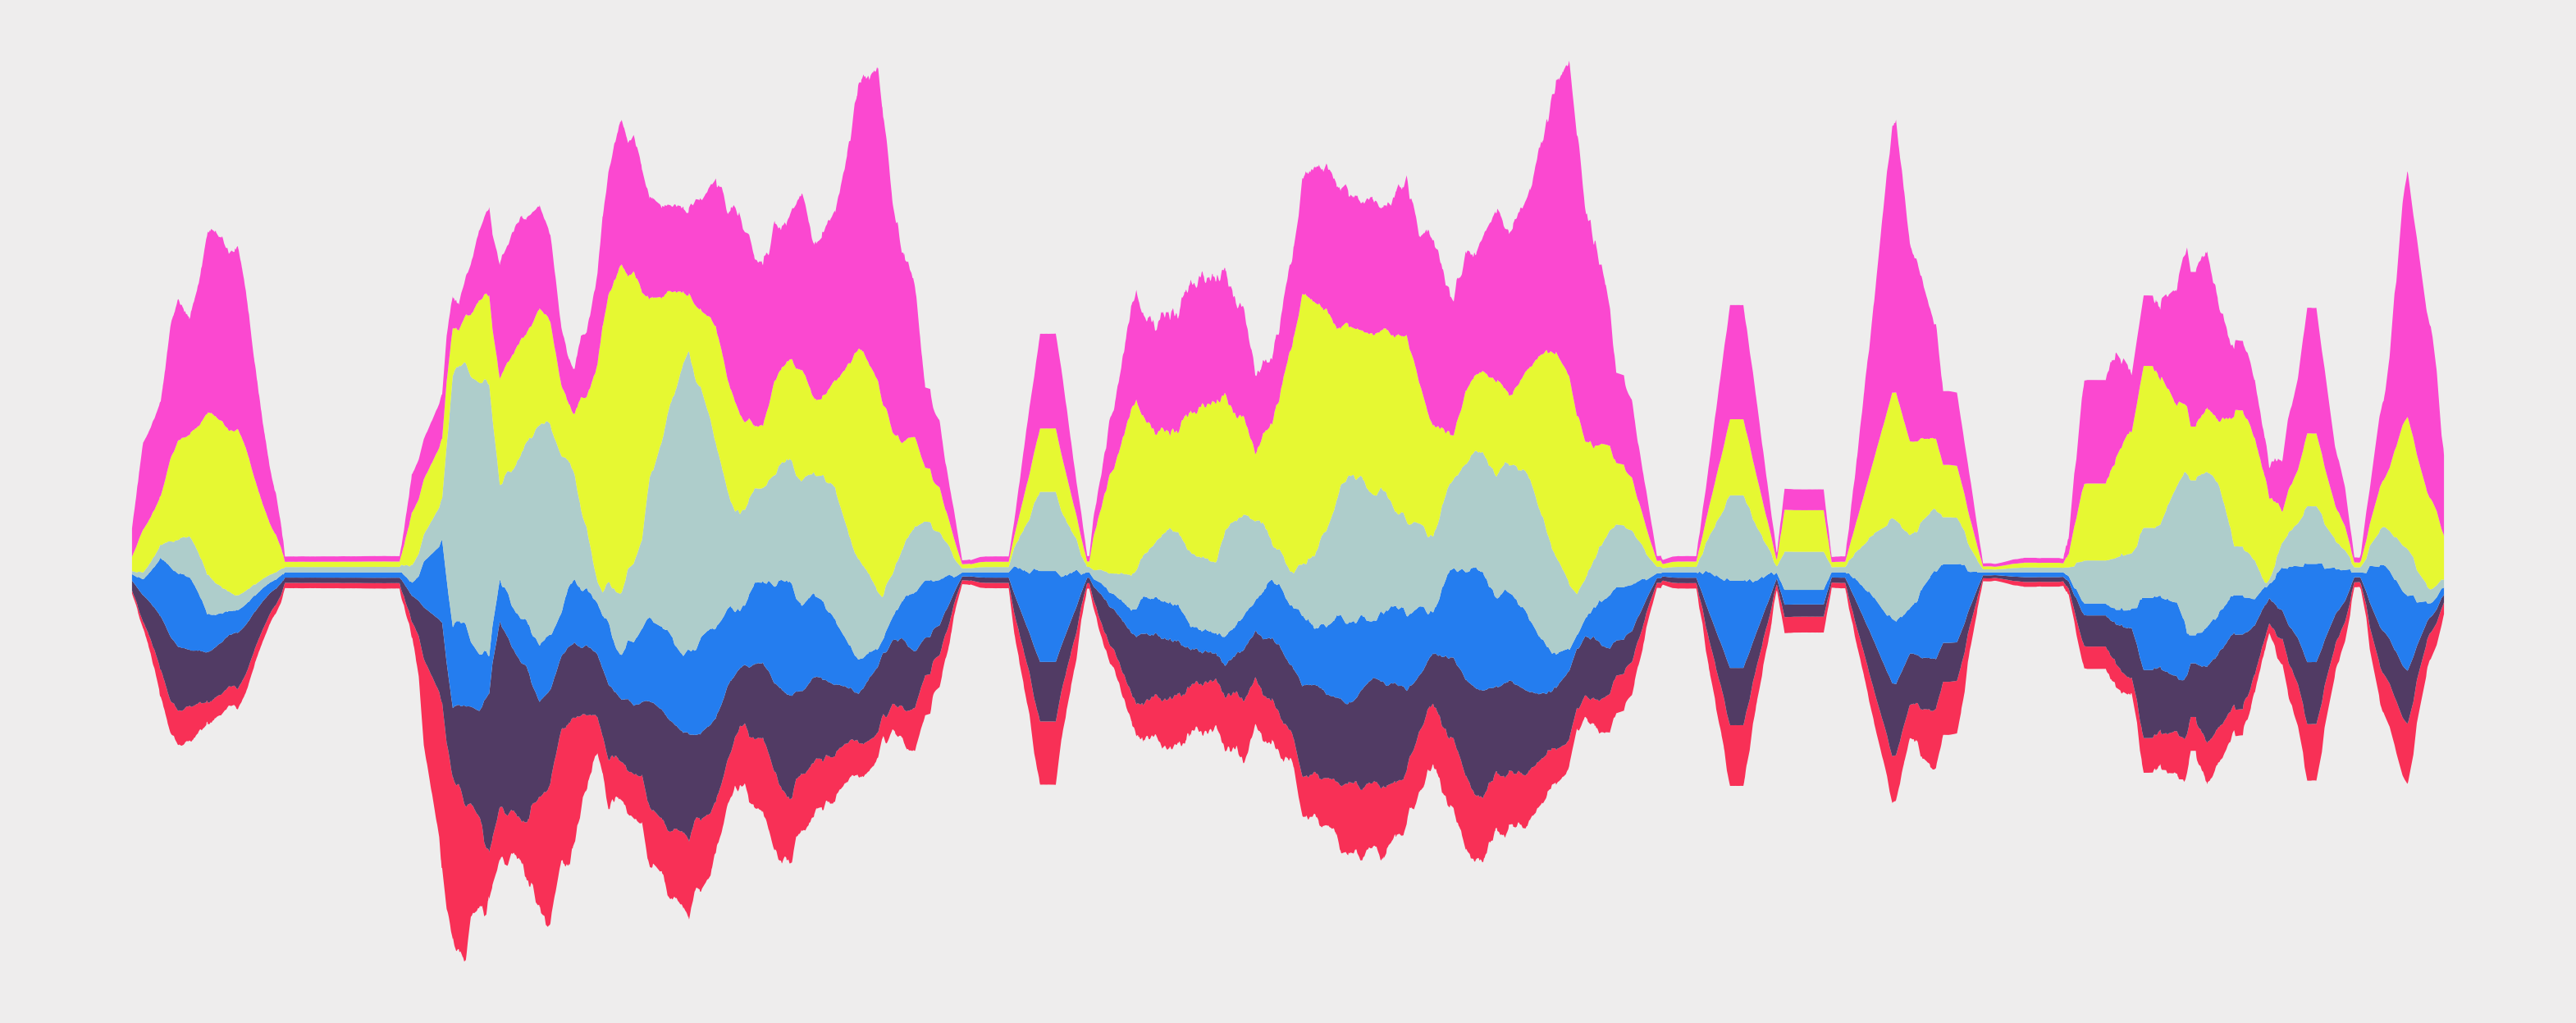

In [414]:
stackplt()

## Animated Visualization

The idea is quite the same but every every second will have its frames to make a clip

In [416]:
res['ch'] = [0.5 if ch == 'NC' else 1 if ch[-1] != 'm' else 0 for ch in res['chord']]
res['corner'] = res['ch'].rolling(window=100).mean()
q = """ select round(r.time*30,0) as frame
    , avg(r.ch) as ch
    , min(r.ch) as ch_min
    , max(r.ch) as ch_max
    , avg(coalesce(r.corner, 0.5)) as crn
    , avg(r.dB)+80.0 as dB
    , avg(case words
            when '' then 0.166666666
            else r.Happy end) as Happy
    , avg(case words
            when '' then 0.166666666
            else r.Excited end) as Excited
    , avg(case words
            when '' then 0.166666666
            else r.Bored end) as Bored
    , avg(case words
            when '' then 0.166666666
            else r.Angry end) as Angry
    , avg(case words
            when '' then 0.166666666
            else r.Fear end) as Fear
    , avg(case words
            when '' then 0.166666666
            else r.Sad end) as Sad
from res as r
group by frame
"""
res2 = sqldf(q)

In [417]:
res2.head(5)

,frame,ch,ch_min,ch_max,crn,dB,Happy,Excited,Bored,Angry,Fear,Sad
0,0.0,1.00,1.0,1.0,0.5,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
1,1.0,1.00,1.0,1.0,0.5,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
2,2.0,1.00,1.0,1.0,0.5,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
3,3.0,0.75,0.5,1.0,0.5,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
4,4.0,1.00,1.0,1.0,0.5,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [356]:
palс = ["#F84440", "#504587", "#4185EF", "#AECDCB", '#E2F834', '#FB63EE']

def mult_rgba(col, mult):
    return (col[0]*mult, col[1]*mult, col[2]*mult, 1/6)

def to_rgba(clrs):
    clrs = clrs/sum(clrs)
    c = list(zip(palс, list(clrs)))
    cl = []
    for i in c:
        rgba = colors.to_rgba(i[0])
        cl.append(mult_rgba(rgba, i[1]))
    return tuple(np.array(cl).sum(axis=0))

def to_rgba_max(clrs):
    mi = np.argmax(clrs)
    return colors.to_rgba(palс[mi])

100%|██████████| 6178/6178 [00:02<00:00, 2333.74it/s]


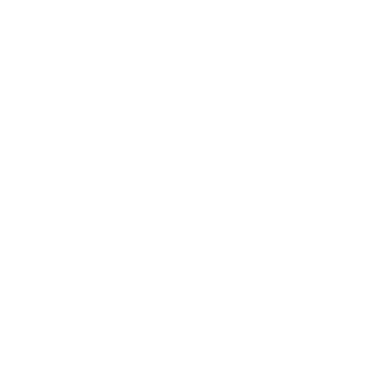

In [486]:
mv = res2['dB'].max()
dB = res2['dB'].rolling(window=10).mean()

crn = res2['crn'] - res2['crn'].mean()+0.5
crn = crn.apply(lambda x: max(0, x))
crn = crn+0.65

fig = plt.figure(figsize=(5,5), dpi=72)
ax = plt.Axes(fig, [0,0,1,1])
ax.set_axis_off()

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
fig.add_axes(ax)

camera = Camera(fig)
ln = len(res2)

ord_c = ['Angry','Fear','Sad','Bored','Happy', 'Excited']
clrs = res2[ord_c].to_numpy()

for i in tqdm(range(0, ln)):
    if np.isnan(dB[i]):
        dB[i]=0
    sz = int(dB[i]/2)+1
    bb = mtransforms.Bbox([[-1*sz, -1*sz], [1*sz, 1*sz]])
    p_fancy = FancyBboxPatch((bb.xmin, bb.ymin),
                                 abs(bb.width), abs(bb.height),
                                 boxstyle="round4,pad=.0, rounding_size="+str(sz*crn[i]),
                                 fc=(to_rgba_max(clrs[i])),
                                 ec=(to_rgba_max(clrs[i])), zorder=4)
    ax.add_patch(p_fancy)
    camera.snap()

anim = camera.animate()

anim.save(_ID+'.mp4', fps=30, writer='ffmpeg', savefig_kwargs={'facecolor':'#303030'})
#HTML(anim.to_html5_video())

In [488]:
import ffmpeg

input_video = ffmpeg.input(_ID+'.mp4')
input_audio = ffmpeg.input(_ID+'.mp3')

ffmpeg.concat(input_video, input_audio, v=1, a=1).output(_ID+'msc_maxclr.mp4').run()

(None, None)

In [367]:
Video(_ID+"_maxclr.mp4")

In [484]:
crn.max()

0.7143954354159885

100%|██████████| 6178/6178 [00:16<00:00, 380.27it/s]


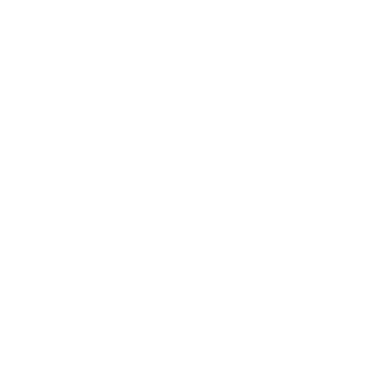

In [495]:
mv = res2['dB'].max()
dB = res2['dB'].rolling(window=10).mean()

crn = res2['crn'] - res2['crn'].mean()+0.5
crn = crn.apply(lambda x: max(0, x))
crn = crn+0.65

fig = plt.figure(figsize=(5,5), dpi=72)
ax = plt.Axes(fig, [0,0,1,1])
ax.set_axis_off()

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
fig.add_axes(ax)

camera = Camera(fig)
ln = len(res2)

ord_cc = ['Bored','Sad','Fear','Angry','Excited','Happy']

col_dict = {'Angry':"#F84440",
            'Fear':"#504587",
            'Sad':"#4185EF",
            'Bored':"#AECDCB",
            'Happy':'#E2F834',
            'Excited':'#FB63EE'   
}
cltr_st = res2[ord_cc].to_numpy()

for i in tqdm(range(0, ln)):
    if np.isnan(dB[i]):
        dB[i]=0
    sz = int(dB[i]/2)+1
    sz_coef = 0.0
    for ci, em in enumerate(ord_cc):
        sz_coef=sz_coef+cltr_st[i][ci] if ci < 5 else 1.0
        bb = mtransforms.Bbox([[-1*sz*sz_coef, -1*sz*sz_coef], [1*sz*sz_coef, 1*sz*sz_coef]])
        p_fancy = FancyBboxPatch((bb.xmin, bb.ymin),
                                     abs(bb.width), abs(bb.height),
                                     boxstyle="round4,pad=.0, rounding_size="+str(sz_coef*sz*crn[i]),
                                     fc=col_dict[em],
                                     ec=col_dict[em], zorder=6-ci)
        ax.add_patch(p_fancy)
    camera.snap()

anim = camera.animate()

anim.save(_ID+'.mp4', fps=30, writer='ffmpeg', savefig_kwargs={'facecolor':'#303030'})
#HTML(anim.to_html5_video())

In [496]:
import ffmpeg

input_video = ffmpeg.input(_ID+'.mp4')
input_audio = ffmpeg.input(_ID+'.mp3')

ffmpeg.concat(input_video, input_audio, v=1, a=1).output(_ID+'_rainb.mp4').run()

(None, None)

In [497]:
Video(_ID+"_rainb.mp4")

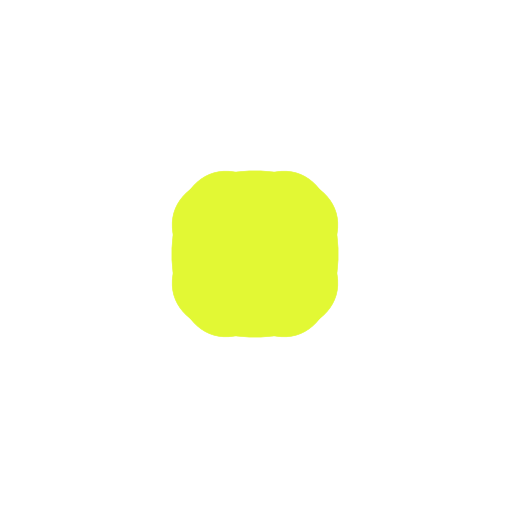

In [485]:
fig = plt.figure(figsize=(10,10), dpi=50)
ax = plt.Axes(fig, [0,0,1,1])
ax.set_axis_off()

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
fig.add_axes(ax)

sz=1
sz_coef=1
bb = mtransforms.Bbox([[-1*sz*sz_coef, -1*sz*sz_coef], [1*sz*sz_coef, 1*sz*sz_coef]])
p_fancy = FancyBboxPatch((bb.xmin, bb.ymin),
                                     abs(bb.width), abs(bb.height),
                                     boxstyle="round4,pad=.0, rounding_size="+str(sz_coef*sz*1.34),
                                     fc=col_dict[em],
                                     ec=col_dict[em], zorder=6-ci)
ax.add_patch(p_fancy)
plt.show()